In [24]:
import pandas as pd
import numpy as np
import torch
import random
data = pd.read_csv(r'datasets\费县建模数据424-516.csv', header=1)

In [25]:
# 解析表中数据，并合并
data40 = np.array(data.iloc[0:-1:2,1:])
print('数据集总大小',data40.shape,'采样周期为40s')
Load = data40[:, 0]
Total_coal = data40[:, 1]
O2set = data40[:, 2]
FuelAF = data40[:, 3:9]
SecA = (data40[:, 9] + data40[:, 10])/2
SecB = (data40[:, 11] + data40[:, 12])/2
SecC = (data40[:, 13] + data40[:, 14])/2
SecD = (data40[:, 15] + data40[:, 16])/2
SecE = (data40[:, 17] + data40[:, 18])/2
SecF = (data40[:, 19] + data40[:, 20])/2
Sofa =  (data40[:, 21] + data40[:, 22] + data40[:, 23] + data40[:, 24])/4
NOxsample = (data40[:, 26] + data40[:, 27])/2
NOx = data40[:, -1]

# 归一化
# 对数据归一化到[0,1] 
Load_max = 630
Load_min = 260
NOx_max = 650
NOx_min = 150
Sec_max = 100
Sec_min = 0
Sofa_max = 100
Sofa_min = 30
O2_max = 8
O2_min = 1.2
Fuel_max = 100
Fuel_min = 0

Load = (Load - Load_min)/(Load_max - Load_min)
O2set = (O2set - O2_min)/(O2_max - O2_min)
FuelAF = (FuelAF -Fuel_min)/(Fuel_max - Fuel_min)
SecA = (SecA - Sec_min)/(Sec_max - Sec_min)
SecB = (SecB - Sec_min)/(Sec_max - Sec_min)
SecC = (SecC - Sec_min)/(Sec_max - Sec_min)
SecD = (SecD - Sec_min)/(Sec_max - Sec_min)
SecE = (SecE - Sec_min)/(Sec_max - Sec_min)
SecF = (SecF - Sec_min)/(Sec_max - Sec_min)
Sofa = (Sofa- Sofa_min)/(Sofa_max - Sofa_min)
NOx = (NOx - NOx_min)/(NOx_max - NOx_min)

variables = np.zeros((len(NOx), 16))
variables[:,0] = Load  # 负荷状态
variables[:,1] = O2set  # 省煤器出口氧量设定值
variables[:,2:8] = FuelAF  # 各个给煤机给煤量
variables[:,8] = SecA  # 风门开度
variables[:,9] = SecB
variables[:,10] = SecC
variables[:,11] = SecD
variables[:,12] = SecE
variables[:,13] = SecF
variables[:,14] = Sofa 
variables[:,15] = NOx  # NOx自回归项
print('时间序列', variables.shape)

# # 估计均值与方差
# std = variables[0:8000,:].std(0)
# mean = variables[0:8000,:].std(0)
# print(std.shape, mean.shape)
# # 对数据集标准化，前15个操作量，考虑到NOx非平稳，后面做batch_norm
# variables[:,0:15] = (variables[:,0:15]-mean[0:15])/std[0:15]

数据集总大小 (45900, 38) 采样周期为40s
时间序列 (45900, 16)


### 构造样本集合，并划分数据集
训练集包含全部负荷段，这样模型包括了系统的全部动态特性，但随着时间推移，之后的多步预测性能下降\
得到X,Y： \
X为(Samples_size, Feature_size), \
Y为下一时刻的目标值，即为预测值，可理解为时间序列预测问题的Lables\

In [26]:
data_len = variables.shape[0] 
st = 50
ed = 8000
Y = NOx[st:ed].reshape(-1,1)  # 对应时刻的预测目标
delays = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1] # 共计16个变量，每个变量的迟延时间
orders = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]    # 共计16个变量，每个变量的输入阶数

X = np.zeros((ed-st,sum(orders)))
count = 0;
for i in range(len(delays)):
    delay = delays[i]
    order = orders[i]
    for j in range(order):
        X[:,count] = variables[st-delay-j:ed-delay-j,i]
        count += 1
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)
print(f'X维度{X.shape} \tY维度{Y.shape}')
print(X[1:,-1] == Y[:-1].reshape(-1))
print(X[100,14] == variables[100+st-1,14])

X维度torch.Size([7950, 16]) 	Y维度torch.Size([7950, 1])
tensor([True, True, True,  ..., True, True, True])
tensor(True)


### 划分训练集和验证集 
yield x_enc, x_dec, y, (nox_mean, nox_std)\
x_enc (batch_size, time_step, featrue_size)\

In [27]:
def random_iter(x_train, y_train, batch_size, enc_time_step, dec_time_step, stride):
    offset = random.randint(0, stride)  # 随机开始
    initial_indices = (np.arange(offset, len(x_train) - enc_time_step - dec_time_step, stride))  # 样本开始索引
    random.shuffle(initial_indices)  # 随机打断样本开始索引

    # 注意的是，y_train值已经前向推进了一步
    def data(pos, sign):
        if sign == 1:
            return x_train[pos:pos + enc_time_step]
        if sign == 2:
            x_dec = x_train[pos + enc_time_step:pos + enc_time_step + dec_time_step].clone()
            # 第一维保持不变    # dec中负荷保持常数
            x_dec[1:, 0] = x_dec[0, 0]
            return x_dec
        if sign == 3:
            return y_train[pos + enc_time_step:pos + enc_time_step + dec_time_step]

    num_batches = len(initial_indices) // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        x_enc = torch.stack([data(j, 1) for j in initial_indices_per_batch])
        x_dec = torch.stack([data(j, 2) for j in initial_indices_per_batch])
        y = torch.stack([data(j, 3) for j in initial_indices_per_batch])
        # 对 NOx 归一化 仅batch
#         nox_mean = x_enc[:, :, -1].mean(1)
#         nox_std = x_enc[:, :, -1].std(1)
        
#         x_enc[:, :, -1] = (x_enc[:, :, -1] - nox_mean.reshape(-1, 1))/(nox_std.reshape(-1, 1)+1e-6)
#         x_dec[:, :, -1] = (x_dec[:, :, -1] - nox_mean.reshape(-1, 1))/(nox_std.reshape(-1, 1)+1e-6)
#         y = (y - nox_mean.reshape(-1, 1, 1))/(nox_std.reshape(-1, 1, 1)+1e-6)
        yield x_enc, x_dec, y


class RandomDataLoader:
    def __init__(self, x_train, y_train, batch_size, enc_time_step, dec_time_step, stride):
        self.x_train, self.y_train = x_train, y_train
        self.batch_size = batch_size
        self.enc_time_step, self.dec_time_step, self.stride = enc_time_step, dec_time_step, stride

    def __iter__(self):
        return random_iter(self.x_train, self.y_train, self.batch_size,
                                self.enc_time_step, self.dec_time_step, self.stride)

    

def split(X, Y, test_size=0.25):
    train_num = int(len(X)*(1-test_size))
    X_train = X[:train_num,]
    y_train = Y[:train_num,]
    X_test = X[train_num:,]
    y_test = Y[train_num:,]
    return X_train, X_test, y_train, y_test



x_train, x_val, y_train, y_val = split(X, Y, test_size=0.25)
train_len = 5962
val_len = 1988
print(f'X_train.shape: {x_train.shape}, X_val.shape:{x_val.shape}')

seed = 42
random.seed()
batch_size = 128
encoder_len = 20
decoder_len = 15
stride = 1
train_dl = RandomDataLoader(x_train, y_train, batch_size, encoder_len, decoder_len, stride)
val_dl = RandomDataLoader(x_val, y_val, batch_size, encoder_len, decoder_len, stride)

for x_enc, x_dec, y in train_dl:
    print('x_enc.shape', x_enc.shape, '\tx_dec.shape', x_dec.shape, '\ty.shape', y.shape)
    break

X_train.shape: torch.Size([5962, 16]), X_val.shape:torch.Size([1988, 16])
x_enc.shape torch.Size([128, 20, 16]) 	x_dec.shape torch.Size([128, 15, 16]) 	y.shape torch.Size([128, 15, 1])


### 定义模型

In [28]:
from torch import nn
import math
import time

class RNNModel(nn.Module):
    def __init__(self, feature_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.feature_size = feature_size
        self.num_hiddens = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout 
        
        self.rnn = nn.LSTM(input_size=feature_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(self.num_hiddens, int(self.num_hiddens/2)),
            nn.Linear(int(self.num_hiddens/2), 1))
        
        self.val_loss_list = []  # 存储验证集每个epoch的损失
        self.train_loss_list = []  # 存储训练集每个epoch的损失
        self.min_loss = 10e6
  
    def encode(self, x_enc, state0):
        # LSTM state为元组形式，包括(h0,c0)
        # x为[时间步, batch_size, feature_size]
        # RNN 返回为output, (h_n, c_n)  output为(时间步, bath_size , hidden_size) h_n为（num_layers, bath_size, Hidden）
        _, state = self.rnn(x_enc, state0)
        return state
        
    def decode(self, x_dec, state):
        H, state = self.rnn(x_dec, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,1)。
        y_hat = self.fc(H.reshape(-1, self.num_hiddens))
        return y_hat, state

    def forward(self, x_enc, x_dec):
        state = self.encode(x_enc)
        y_hat,_ = self.decode(x_dec, state)
        return y_hat
    
    def predict(self ,x_enc, x_dec, state0):
        # batch归一化后的值，x_enc x_dec(时间步，batch，features)
        y = []
        with torch.no_grad():
            self.eval()
            # 迭代多步，并且每次预测值替换x_dec中的真实值
            state = self.encode(x_enc, state0)
            y_hat, state = self.decode(x_dec[0, :, :].reshape(1, 1, -1), state)
            y.append(y_hat)
            for i in range(1, x_dec.shape[0]):
                # 预测值替换, 获得下一步的decode输入
                x_dec_next = x_dec[i, :, :].clone().reshape(1, 1, -1)
                x_dec_next[...,-1] = y_hat
                # 氧量不变已经处理过
                y_hat, state = self.decode(x_dec_next.reshape(1, 1, -1), state)
                y.append(y_hat)
        return torch.cat(y)
    
    
    def init_state(self, batch_size, device):
        return (torch.zeros((self.num_layers, batch_size, self.num_hiddens), device=device),
                torch.zeros((self.num_layers, batch_size, self.num_hiddens), device=device))
        
    

# 初始化模型训练参数
def init_net(m):
    with torch.no_grad():
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
            if m.bias is not None:
                fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(m.weight)
                bound = 1 / math.sqrt(fan_in)
                torch.nn.init.uniform_(m.bias, -bound, bound)
        elif isinstance(m, nn.Conv2d):
            n = m.in_channels
            print(n)
            torch.nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
            if m.bias is not None:
                fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(m.weight)
                bound = 1 / math.sqrt(fan_in)
                torch.nn.init.uniform_(m.bias, -bound, bound)
        elif isinstance(m, nn.LSTM):
            stdv = 1.0 / math.sqrt(m.hidden_size)
            for weight in m.parameters():
                torch.nn.init.uniform_(weight, -stdv, stdv)
                # torch.nn.init.constant_(weight, 1)


# 评价测试集
def evaluate_mae(data_iter, net, device=None):
    net.eval()
    if device is None:
        device = list(net.parameters())[0].device
    mae_sum, n = 0.0, 0
    with torch.no_grad():
        for x_enc, x_dec, y in data_iter:
            # x[batch_size,time_step,features]  y[batch_size,time_step,1]
            x_enc.transpose_(0, 1)
            x_dec.transpose_(0, 1)
            y.transpose_(0, 1)
            x_enc = x_enc.to(device)
            x_dec = x_dec.to(device)
            y = y.to(device)
       
            state0 = net.init_state(batch_size=x_enc.shape[1], device=device)
            state = net.encode(x_enc, state0)
            y_hat,_ = net.decode(x_dec, state)  # 输出的y_hat(时间步数*批量大小,1) state(D∗num_layers,N,H)
            mae_sum += (torch.abs(y_hat.reshape(-1) - y.reshape(-1)) * (NOx_max-NOx_min)).sum().cpu().item()
            n += y.numel()
    return mae_sum / n


def call_save_model(net, val_loss):
    if val_loss < net.min_loss:
        net.min_loss = val_loss
        torch.save(net.state_dict(), "model/LSTMCL_base.pth")
        print(f'call:{val_loss}')

def call_early_stop(net, val_loss):
    if val_loss < net.min_loss:
        net.min_loss = val_loss
        torch.save(net.state_dict(), "model/LSTMCL_base.pth")
        print(f'call:{val_loss}')
        net.early_stop_sign = 0
    else:
        net.early_stop_sign += 1
        
    if net.early_stop_sign >= 10:
        return True
    else:
        return False
    

# 训练模型
def train_net(net, train_iter, val_iter, optimizer, loss, device, epochs):
    net.to(device)
    net.val_loss_list = []  # 记录验证集每个epoch的损失
    net.train_loss_list = []  # 记录训练集每个epoch的损失
    for epoch in range(epochs):
        train_l_sum, train_mae_sum =  0.0, 0.0
        n, start = 0, time.time()
        for x_enc, x_dec, y in train_iter:
            # x[batch_size, time_step, features]  y[batch_size, time_step, 1]
            # trans to x[time_step, batch_size, features]
            x_enc.transpose_(0, 1)
            x_dec.transpose_(0, 1)
            y.transpose_(0, 1)
            x_enc = x_enc.to(device=device)
            x_dec = x_dec.to(device=device)
            y = y.to(device=device)
            net.train()
            state0 = net.init_state(batch_size=x_enc.shape[1], device=device)
            state = net.encode(x_enc, state0)
            y_hat,_ = net.decode(x_dec, state)
            # y_hat = net(x_enc, x_dec)  # 输出的y_hat(时间步数*批量大小,1) state(D∗num_layers,N,H)
            # print(y_hat.shape, y.shape)
            l = loss(y_hat.reshape(-1), y.reshape(-1))
            l.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            with torch.no_grad():
                train_l_sum += l.cpu().item()
                train_mae_sum += (torch.abs(y_hat.reshape(-1) - y.reshape(-1)) * (NOx_max-NOx_min)).sum().cpu().item()
                n += y.numel()
        # every epoch to do
        # 评价验证集
        val_mae = evaluate_mae(val_iter, net, device)  # 均值MAE
        net.train_loss_list.append(train_mae_sum/n)
        net.val_loss_list.append(val_mae)  # 和损失相等都为MAE这里

        # 保存最优模型
        call_save_model(net, val_mae)
        # early_stop = call_early_stop(net, val_mae)
        # early_stop = False
#         if early_stop:
#             break

        # 展示
        print('epoch %d, loss %.4f, train mae %.3f, test_mae %.3f, time %.2f sec'
              %(epoch, train_l_sum/n, train_mae_sum/n, val_mae, time.time()-start))

    # 保存loss
    torch.save(torch.tensor(net.val_loss_list), "loss/LSTMCL_base_val_loss.pt")
    torch.save(torch.tensor(net.train_loss_list), "loss/LSTMCL_base_train_loss.pt")
    return np.min(net.val_loss_list), np.min(net.train_loss_list)

### 离线训练模型

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('training on', device)
net = RNNModel(feature_size=16, hidden_size=64, num_layers=2, dropout=0.4)
net.to(dtype=torch.float32, device=device)
net.apply(init_net)
loss = nn.L1Loss(reduction ='sum')
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-3)
epochs = 130
train_net(net, train_dl, val_dl, optimizer, loss, device, epochs)

training on cuda
call:53.07441596137153
epoch 0, loss 0.0911, train mae 45.570, test_mae 53.074, time 0.67 sec
call:35.571381157769096
epoch 1, loss 0.0596, train mae 29.799, test_mae 35.571, time 0.48 sec
call:31.446087375217015
epoch 2, loss 0.0353, train mae 17.673, test_mae 31.446, time 0.47 sec
call:20.329276055230036
epoch 3, loss 0.0266, train mae 13.296, test_mae 20.329, time 0.46 sec
call:14.793185085720486
epoch 4, loss 0.0203, train mae 10.128, test_mae 14.793, time 0.50 sec
call:13.363930867513021
epoch 5, loss 0.0190, train mae 9.522, test_mae 13.364, time 0.50 sec
call:11.128110758463542
epoch 6, loss 0.0154, train mae 7.704, test_mae 11.128, time 0.51 sec
call:10.676311984592013
epoch 7, loss 0.0149, train mae 7.447, test_mae 10.676, time 0.51 sec
call:9.414092475043402
epoch 8, loss 0.0136, train mae 6.807, test_mae 9.414, time 0.52 sec
call:9.404007093641493
epoch 9, loss 0.0130, train mae 6.495, test_mae 9.404, time 0.52 sec
call:8.399171413845487
epoch 10, loss 0.011

epoch 105, loss 0.0035, train mae 1.734, test_mae 2.449, time 0.53 sec
call:2.1195267571343317
epoch 106, loss 0.0035, train mae 1.755, test_mae 2.120, time 0.53 sec
call:2.0796147410074868
epoch 107, loss 0.0034, train mae 1.709, test_mae 2.080, time 0.54 sec
call:2.0429095458984374
epoch 108, loss 0.0034, train mae 1.697, test_mae 2.043, time 0.53 sec
epoch 109, loss 0.0035, train mae 1.728, test_mae 2.159, time 0.53 sec
epoch 110, loss 0.0045, train mae 2.246, test_mae 2.086, time 0.53 sec
epoch 111, loss 0.0039, train mae 1.933, test_mae 2.625, time 0.53 sec
epoch 112, loss 0.0035, train mae 1.731, test_mae 2.192, time 0.54 sec
epoch 113, loss 0.0036, train mae 1.780, test_mae 2.862, time 0.55 sec
epoch 114, loss 0.0034, train mae 1.708, test_mae 2.313, time 0.55 sec
epoch 115, loss 0.0036, train mae 1.784, test_mae 2.742, time 0.54 sec
epoch 116, loss 0.0043, train mae 2.173, test_mae 5.872, time 0.53 sec
epoch 117, loss 0.0059, train mae 2.941, test_mae 2.133, time 0.53 sec
epoch

(1.8583287556966146, 1.696580347807511)

In [296]:
y_pred.shape

torch.Size([45800, 15])

### 训练网络，非在线学习的评价，仅用前8000个样本训练验证，后面所有的样本用于测试，
1.预测精度随时间的变化

In [60]:
# 加载最优模型
net = RNNModel(feature_size=16, hidden_size=64, num_layers=2, dropout=0.1)
net.load_state_dict(torch.load("model/LSTMCL_base.pth"))
net = net.to(device=device)
# 离线评价
st_test = 50 # ed  # 开始测试时刻
ed_test = data_len - 50 # 预测步长是15
horizon = 15
y_pred = torch.zeros((ed_test-st_test, horizon))
y_true = torch.zeros((ed_test-st_test, horizon))

for t in range(st_test,ed_test):
    # 获得t时刻各个变量的采样值，使用t-19，t-18，...,t时刻数据，预测未来t+1，t+2,...t+15时刻NOx
    # 构造样本 x_enc，x_ed， y_pred, 单个batch
    x_enc = torch.tensor(variables[t-encoder_len:t]).unsqueeze(0)  # (1,time_step=20, feature_size)
    x_dec = torch.tensor(variables[t:t+decoder_len]).unsqueeze(0)  # (1,time_step=15, feature_size)
    y = torch.tensor(variables[t+1:t+decoder_len+1, -1])  # (time_step=15)
    
    # 对NOx batch_norm
#     nox_mean = x_enc[:, :, -1].mean(1)
#     nox_std = x_enc[:, :, -1].std(1)
#     x_enc[:, :, -1] = (x_enc[:, :, -1] - nox_mean.reshape(-1, 1))/nox_std.reshape(-1, 1)
#     x_dec[:, :, -1] = (x_dec[:, :, -1] - nox_mean.reshape(-1, 1))/nox_std.reshape(-1, 1)
    # y = (y - nox_mean)/nox_std
    x_enc.transpose_(0, 1)
    x_dec.transpose_(0, 1)
    x_enc = x_enc.to(device=device, dtype=torch.float32)
    x_dec = x_dec.to(device=device, dtype=torch.float32)
    # print(x_enc.shape, x_dec.shape, y.shape)
    # 迭代15步前向预测
    state0 = net.init_state(batch_size=x_enc.shape[1], device=device)
    y_hat = net.predict(x_enc, x_dec, state0).cpu()  # 返回一个15时间步的预测结果
    # 返回到原始空间中
    y_hat = y_hat*(NOx_max-NOx_min) + NOx_min
    y = y*(NOx_max-NOx_min) + NOx_min
    # print(y.shape, y_hat.shape)
    # 保存预测结果
    y_pred[t-st_test, :] =  y_hat.reshape(-1)
    y_true[t-st_test, :] =  y
    if (t-st_test)%500==0: print('time',t-st_test)
# torch.save(y_pred, "result/LSTM_base_y_pred.pt")
# torch.save(y_true, "result/LSTM_base_y_true.pt")
# y_true = torch.load("result/LSTM_base_y_true.pt")
# y_pred = torch.load("result/LSTM_base_y_pred.pt")        

time 0
time 500
time 1000
time 1500
time 2000
time 2500
time 3000
time 3500
time 4000
time 4500
time 5000
time 5500
time 6000
time 6500
time 7000
time 7500
time 8000
time 8500
time 9000
time 9500
time 10000
time 10500
time 11000
time 11500
time 12000
time 12500
time 13000
time 13500
time 14000
time 14500
time 15000
time 15500
time 16000
time 16500
time 17000
time 17500
time 18000
time 18500
time 19000
time 19500
time 20000
time 20500
time 21000
time 21500
time 22000
time 22500
time 23000
time 23500
time 24000
time 24500
time 25000
time 25500
time 26000
time 26500
time 27000
time 27500
time 28000
time 28500
time 29000
time 29500
time 30000
time 30500
time 31000
time 31500
time 32000
time 32500
time 33000
time 33500
time 34000
time 34500
time 35000
time 35500
time 36000
time 36500
time 37000
time 37500
time 38000
time 38500
time 39000
time 39500
time 40000
time 40500
time 41000
time 41500
time 42000
time 42500
time 43000
time 43500
time 44000
time 44500
time 45000
time 45500


In [3]:
import torch
import numpy as np
y_true = torch.load("result/LSTM_base_y_true.pt")
y_pred = torch.load("result/LSTM_base_y_pred.pt")        

### 指标评价，随时间变化的各步长的MAE， MAPE

In [4]:
def mape(y_pred, y_true):
    loss = ((y_pred - y_true).abs() / (y_true.abs() + 1e-8))*100
    return loss

def mae(y_pred, y_true):
    loss = (y_pred - y_true).abs()
    return loss

y_true = torch.load("result/LSTM_base_y_true.pt")
y_pred = torch.load("result/LSTM_base_y_pred.pt")        
mape = mape(y_pred, y_true)
mae = mae(y_pred, y_true)
print(mape.shape, mae.shape)

# 绘制MAE，MAPE多步随时间变化情况,采用窗口求统计平均
window_len = 300
s, h = mape.shape
mape_window = np.zeros((s//window_len, h))
for i in range(s//window_len):
    mape_window[i, :] = mape[i*window_len:i*window_len+window_len,:].mean(0)
print(mape_window.shape)

torch.Size([45800, 15]) torch.Size([45800, 15])
(152, 15)


### 统计平均绘制表格

In [7]:
train_len = 5962
val_len = 1988

train_st = 0
train_ed = train_st + train_len
val_st = train_ed
val_ed = train_ed + val_len
test_st = val_ed
test_ed = y_pred.shape[0]
window_len = 300
mape_test = mape[test_st:,:] 
mae_test = mae[test_st:,:] 
# 绘制MAE，MAPE多步随时间变化情况,采用窗口求统计平均
window_len = 5000
s, h = mape_test.shape
mape_window_mean = np.zeros((s//window_len, h))
mape_window_std = np.zeros((s//window_len, h))
for i in range(s//window_len):
    mape_window_mean[i, :] = mape_test[i*window_len:i*window_len+window_len,:].mean(0)
    mape_window_std[i, :] = mape_test[i*window_len:i*window_len+window_len,:].std(0)
print(mape_window.shape)
index = [0,6,13]
np.set_printoptions (precision=2, suppress=True) 
for i in index:
    print('预测步数{:.3f}, mape_mean:{}'.format(i+1, mape_window_mean[:,i]))
    print('预测步数{:.3f}, mape_std:{}'.format(i+1, mape_window_std[:,i]))
np.save('result/LSTM_base_mape_window_mean.npy',mape_window_mean)
np.save('result/LSTM_base_mape_window_std.npy',mape_window_std)

(152, 15)
预测步数1.000, mape_mean:[0.59 0.94 0.67 0.98 0.7  0.56 1.12]
预测步数1.000, mape_std:[0.64 0.95 0.64 1.17 0.8  0.48 1.38]
预测步数7.000, mape_mean:[4.94 7.37 5.02 6.33 5.29 4.72 7.9 ]
预测步数7.000, mape_std:[3.75 6.37 4.47 6.14 4.79 3.66 6.98]
预测步数14.000, mape_mean:[ 9.68 15.61  9.36 10.13 10.    9.67 14.84]
预测步数14.000, mape_std:[ 7.33 13.82  9.26  8.81  8.22  7.4  12.34]


In [8]:
# 绘制MAE，MAPE多步随时间变化情况,采用窗口求统计平均
window_len = 5000
s, h = mae_test.shape
mae_window_std = np.zeros((s//window_len, h))
mae_window_mean = np.zeros((s//window_len, h))
for i in range(s//window_len):
    mae_window_mean[i, :] = mae_test[i*window_len:i*window_len+window_len,:].mean(0)
    mae_window_std[i, :] = mae_test[i*window_len:i*window_len+window_len,:].std(0)
# print(mae_window.shape)
index = [0,6,13]
np.set_printoptions(precision=2, suppress=True) 
for i in index:
    print('预测步数{}, mae_mean: {}'.format(i+1, mae_window_mean[:,i]))
    print('预测步数{}, mae_std: {}'.format(i+1, mae_window_std[:,i]))

np.save('result/LSTM_base_mae_window_mean.npy',mae_window_mean)
np.save('result/LSTM_base_mae_window_std.npy',mae_window_std)

预测步数1, mae_mean: [1.78 2.95 1.92 2.28 2.26 1.94 2.81]
预测步数1, mae_std: [1.57 2.97 1.9  2.38 2.28 1.89 2.67]
预测步数7, mae_mean: [15.43 24.28 15.02 15.37 17.64 16.6  21.17]
预测步数7, mae_std: [11.2  23.68 15.4  13.81 16.03 14.56 15.9 ]
预测步数14, mae_mean: [30.22 52.16 28.84 25.64 33.98 33.93 41.16]
预测步数14, mae_std: [21.82 52.46 32.81 22.55 29.74 28.88 31.29]


### 分析验证集单步loss，假设正太分布，确定其mean std
用于在线更新时阈值设置

In [9]:
y_true = torch.load("result/LSTM_base_y_true.pt")
y_pred = torch.load("result/LSTM_base_y_pred.pt")    

train_st = 0
train_ed = train_st + train_len
val_st = train_ed
val_ed = train_ed + val_len
test_st = val_ed
test_ed = y_pred.shape[0]
one_step_error = (y_true - y_pred).abs()[val_st:val_ed,0]
print(one_step_error.shape)
mean = one_step_error.mean()
std = one_step_error.std()
print('mean:', one_step_error.mean(), 'std:', one_step_error.std())
mod_one_step_error = one_step_error[one_step_error<mean+3*std]
mean = mod_one_step_error.mean()
std = mod_one_step_error.std()
print('mean:', mean, 'std:',std)

torch.Size([1988])
mean: tensor(1.9228) std: tensor(2.3662)
mean: tensor(1.6997) std: tensor(1.4791)


<Axes: ylabel='Density'>

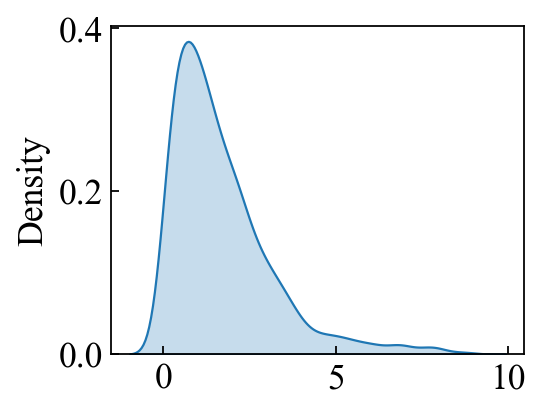

In [13]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
## 画图
config = {
"font.family":"times new roman",    
"font.size": 16,       #14 放大是16
"mathtext.fontset":'stix',
"xtick.direction":"in",
    
"ytick.direction":"in",
}
rcParams.update(config)
fig, ax = plt.subplots(dpi=160, figsize=(5/1.5, 4/1.5))

sns.kdeplot(mod_one_step_error, fill=True, ax=ax, linestyle='-')

# ax.set_ylabel("概率密度",family= 'SimSun')
# ax.set_xlabel("锅炉效率(%)",family= 'SimSun')
# legend_font = {"family":"SimSun", "size":14}
# fig.legend(['时段1-切除', '时段2-投入', '时段3-投入',],frameon=False, fontsize='x-small', bbox_to_anchor=(0.5, 0.87), prop=legend_font)

### 性能随时间变数曲线

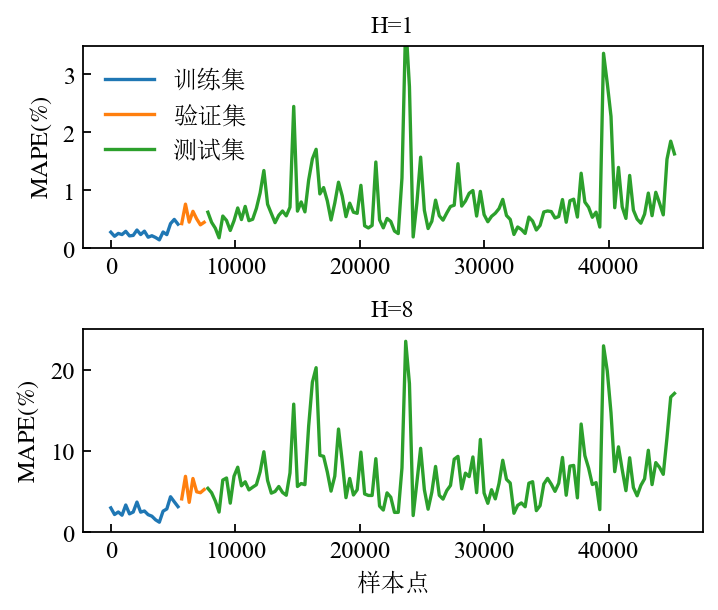

In [10]:
# 绘图
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import matplotlib.ticker as ticker

# create figure
config = {
"font.family":'serif',  
"font.size": 11,    
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
"font.family":"times new roman",
}
# 画板设置
font_size = 11
rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
fig = plt.figure(dpi=160, figsize=(6/1.2, 5/1.2))
# 绘图曲线
window_len = 300
train_st = 0
train_ed = train_st + train_len
val_st = train_ed
val_ed = train_ed + val_len
test_st = val_ed
test_ed = y_pred.shape[0]

train_st, train_ed, val_st, val_ed, test_st, test_ed = [int(i/window_len) for i in [train_st, train_ed, val_st, val_ed, test_st, test_ed]]
h = 0 # 预测步数
ax = fig.add_subplot(211)
ax.plot(np.arange(train_st,train_ed)*window_len, mape_window[train_st:train_ed,h], color=color_list[1], linestyle='-')
ax.plot(np.arange(val_st,val_ed)*window_len, mape_window[val_st:val_ed,h], color=color_list[2], linestyle='-')
ax.plot(np.arange(test_st,test_ed)*window_len, mape_window[test_st:test_ed,h], color=color_list[3], linestyle='-')
ax.set_ylim([0,3.5])
ax.set_title("H=1",fontsize=font_size)
ax.set_ylabel('$\mathrm{MAPE(\%)}$', fontfamily="SimSun", fontsize=font_size)
legend_font = {"family":"SimSun", "size":11}
plt.legend(['训练集', '验证集','测试集'],frameon=False, prop=legend_font)  # ncol=3,  bbox_to_anchor=(0.98, 1.05)

h = 7 # 预测步数
ax = fig.add_subplot(212)
ax.plot(np.arange(train_st,train_ed)*window_len, mape_window[train_st:train_ed,h], color=color_list[1], linestyle='-')
ax.plot(np.arange(val_st,val_ed)*window_len, mape_window[val_st:val_ed,h], color=color_list[2], linestyle='-')
ax.plot(np.arange(test_st,test_ed)*window_len, mape_window[test_st:test_ed,h], color=color_list[3], linestyle='-')
ax.set_ylabel('$\mathrm{MAPE(\%)}$', fontfamily="SimSun", fontsize=font_size)
ax.set_ylim([0,25])
ax.set_title("H=8",fontsize=font_size)
# ax = fig.add_subplot(313)
# h = 13 # 预测步数
# ax.plot(np.arange(train_st,train_ed)*window_len, mape_window[train_st:train_ed,h], color=color_list[1], linestyle='-')
# ax.plot(np.arange(val_st,val_ed)*window_len, mape_window[val_st:val_ed,h], color=color_list[2], linestyle='-')
# ax.plot(np.arange(test_st,test_ed)*window_len, mape_window[test_st:test_ed,h], color=color_list[3], linestyle='-')
# ax.set_ylabel('$\mathrm{MAPE(\%)}$', fontfamily="SimSun", fontsize=font_size)
ax.set_xlabel('样本点', fontfamily="SimSun", fontsize=font_size)

plt.subplots_adjust(left=None, bottom=0.15, right=None, top=None, wspace=0.1, hspace=0.4)#wspace 子图横向间距， hspace 代表子图间的纵向距离，left 代表位于图像不同位置

### 所有测试样本的MAPE和MAE

In [11]:
def MAPE(y_pred, target):
    loss = ((y_pred - target).abs() / (target.abs() + 1e-8)).mean(0)*100
    return loss

def MAE(y_pred, target):
    loss = (target - y_pred).abs().mean(0)
    return loss
y_true = torch.load("result/LSTM_base_y_true.pt")
y_pred = torch.load("result/LSTM_base_y_pred.pt")   
train_st = 0
train_ed = train_st + train_len
val_st = train_ed
val_ed = train_ed + val_len
test_st = val_ed
test_ed = y_pred.shape[0]

test_multi_step_mae =  MAE(y_pred[test_st:test_ed], y_true[test_st:test_ed])
test_multi_step_mape = MAPE(y_pred[test_st:test_ed], y_true[test_st:test_ed])
index = [0, 4, 9, 14]
print(f'net1 MAE:{[test_multi_step_mae[i].item() for i in index]}, mean:{test_multi_step_mae.mean().item()}')
print(f'net1 MAPE:{[test_multi_step_mape[i].item() for i in [0,4,9,14]]}, mean:{test_multi_step_mape.mean().item()}')

net1 MAE:[2.307962656021118, 11.350961685180664, 27.75448226928711, 36.63987350463867], mean:20.44270133972168
net1 MAPE:[0.8156988024711609, 3.86352801322937, 9.275599479675293, 11.994029998779297], mean:6.817416667938232


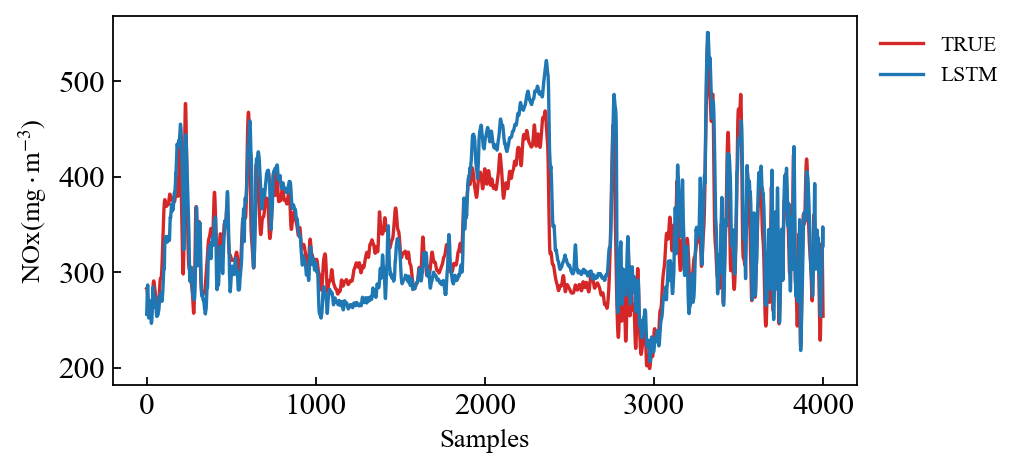

In [68]:
## 画图
## 画图
config = {
"font.family":"times new roman",    
"font.size": 14,       #14 放大是16
"mathtext.fontset":'stix',
"xtick.direction":"in",
    
"ytick.direction":"in",
}
rcParams.update(config)

h = 10
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
plt.figure(dpi=160, figsize=(6,3))
plt.plot(y_true[8000:12000,h],color = color_list[4],linewidth=1.5)
plt.plot(y_pred[8000:12000,h],color = color_list[0],linewidth=1.5)


plt.xlabel("Samples",{"size":12})
plt.ylabel("NOx($\mathrm{mg \cdot m^{-3}}$)",{"size":12})
plt.legend(['TRUE', 'LSTM'],frameon=False, fontsize = 'x-small',bbox_to_anchor=(1.005, 1) )

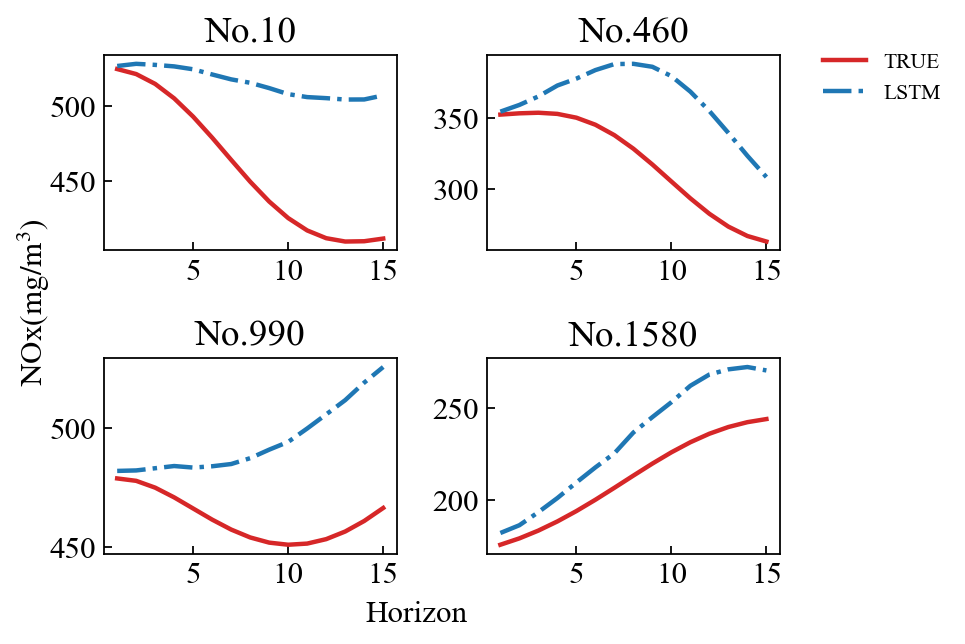

In [50]:
config = {
"font.family":'serif',  
"font.size": 14,       #14 放大是16
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
#"font.serif": ['SimSun'],
"font.family":"times new roman",
}
rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
x = np.arange(1,16)
fig, ax1 = plt.subplots(2,2, figsize=(5,4), dpi=160)


point = 16000
ax1[0,0].plot(x, y_true[point-1,:], color=color_list[4], linestyle='-', linewidth=2)
ax1[0,0].plot(x, y_pred[point-1,:], color=color_list[0], linestyle='-.', linewidth=2)
ax1[0,0].set_title('No.10')


point = 29000
ax1[0,1].plot(x, y_true[point-1,:], color=color_list[4], linestyle='-', linewidth=2)
ax1[0,1].plot(x, y_pred[point-1,:], color=color_list[0], linestyle='-.', linewidth=2)
ax1[0,1].set_title('No.460')

point = 35000
ax1[1,0].plot(x, y_true[point-1,:], color=color_list[4], linestyle='-', linewidth=2)
ax1[1,0].plot(x, y_pred[point-1,:], color=color_list[0], linestyle='-.', linewidth=2)

ax1[1,0].set_title('No.990')

point = 41000   # 1380
ax1[1,1].plot(x, y_true[point-1,:], color=color_list[4], linestyle='-', linewidth=2)
ax1[1,1].plot(x, y_pred[point-1,:], color=color_list[0], linestyle='-.', linewidth=2)

ax1[1,1].set_title('No.1580')
#ax1[1,1].set_ylim([290,320])

egend_font = {"family" : "serif"}
fig.legend(['TRUE', 'LSTM', ],frameon=False,\
           fontsize='x-small', bbox_to_anchor=(1.18, 0.92))

fig.text(0.5, 0, "Horizon", ha='center')
fig.text(0, 0.5, "NOx($\mathrm{mg/m^{3}}$)", va='center', rotation='vertical')   
plt.tight_layout()